In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt

from random import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import h5py
import pandas as pd
import os.path
from keras.models import load_model
import tensorflow as tf
from IPython.display import HTML
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
class ViolenceDetection:
    def __init__(self,list_clases):
        # Number of classes for classification (Violence-No Violence)
        self.list_clases=list_clases

    def get_frames(self,current_dir, file_name):
        '''
        Function used to get 20 frames from a video file and convert the frame to a suitable format for the neural network.
        '''
        in_file, images  = os.path.join(current_dir, file_name), []
        video_capture = cv2.VideoCapture(in_file)
        success,image = video_capture.read()
        for i in range(20):
            RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            res = cv2.resize(RGB_img, dsize=(224, 224),interpolation=cv2.INTER_CUBIC)
            images.append(res)
            success,image = video_capture.read()
        result = (np.array(images) / 255.).astype(np.float16)
        return result

    def label_video_names(self,in_dir):
        '''
        Function that receives the amount of data downloaded and labels it
        '''
        # list containing video names, list containin video labels [1, 0] if it has violence and [0, 1] if not
        names, labels = [], []
        for current_dir, dir_names,file_names in os.walk(in_dir):
            for file_name in file_names:
                if file_name[0:2] == 'no':
                    labels.append([0,1])
                else:
                    labels.append([1,0])
                names.append(file_name)
        data = list(zip(names,labels))
        shuffle(data)
        names, labels = zip(*data)
        return names, labels


    def get_transfer_values(self,current_dir, file_name):
        '''
        Function to process 20 video frames through VGG19 and get transfer values.
        '''
        image_batch = self.get_frames(current_dir, file_name)

        shape = (20, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        transfer_values = \
        image_model_transfer.predict(image_batch)
        return transfer_values


    def get_transfer(self,image_model):
        # classification-layer which is named fc2. This is a fully-connected (or dense) layer.
        transfer_layer = image_model.get_layer('fc2')
        image_model_transfer = Model(inputs=image_model.input,outputs=transfer_layer.output)
        transfer_values_size = K.int_shape(transfer_layer.output)[1]
        return image_model_transfer, transfer_values_size

    def process_all_data(self,file_name_h5py):
        joint_transfer, count=[],0
        with h5py.File(file_name_h5py, 'r') as f:
            X_batch = f['data'][:]
            y_batch = f['labels'][:]
        for i in range(int(len(X_batch)/20)):
            inc = count+20
            joint_transfer.append([X_batch[count:inc],y_batch[count]])
            count =inc
        data, target=[], []
        for i in joint_transfer:
            data.append(i[0])
            target.append(np.array(i[1]))

        return data, target


    def get_model(self):
        model = Sequential()
        model.add(LSTM(512, input_shape=(20, 4096)))
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('sigmoid'))
        model.add(Dense(2))
        model.add(Activation('softmax'))
        model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
        return model

    def fit_model(self,model):
        # This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.
        # The "monitor" allows you to specify the performance measure to monitor in order to end training.
        Callback_Stop_Early = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3)
        history = model.fit(np.array(data[0:720]), np.array(target[0:720]), callbacks = Callback_Stop_Early, epochs=200, validation_data=(np.array(data[720:]), np.array(target[720:])),  batch_size=500, verbose=2)
        return history

    def show(self,history,name):
        plt.plot(history[name])
        plt.plot(history['val_'+ name])
        plt.title('model '+ name)
        plt.ylabel(name)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig('/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/data/'+ name +'.png')
        plt.show()

    def evaluate(self,model,data_test,target_test):
        result = model.evaluate(np.array(data_test), np.array(target_test))
        pred = model.predict(np.array(data_test))
        df=pd.DataFrame([target_test]).T.astype('str')
        binary_target=df[0].replace('[1. 0.]',1).replace('[0. 1.]',0).values.tolist()
        binary_predictions = [0 if i[1] >=0.5 else 1 for i in pred]
        print("Accuracy Classifier: {}%".format(round(accuracy_score(binary_predictions, binary_target)*100,2)))
        print(classification_report(binary_predictions, binary_target))
        cm=confusion_matrix(binary_predictions, binary_target)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('VGG19')
        plt.savefig('/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/data/VGG19.png')
        plt.show()

    def check_test(self,data_test):
        prediction = model.predict(np.array(data_test))
        queue=[]
        queue.append(prediction)
        results = np.array(queue).mean(axis=1)
        print(results)
        predict_class = self.list_clases[np.argmax(results)]
        print('Test prediction is: ',predict_class)


    def check_vedio(self,in_dir, name_vedio):
        vec_transfer= self.get_transfer_values(in_dir,name_vedio)
        vec_test, queue=[], []
        vec_test.append(vec_transfer)
        prediction = model.predict(np.array(np.array(vec_test)))
        queue.append(prediction)
        results = np.array(queue).mean(axis=1)
        predict_class = self.list_clases[np.argmax(results)]
        temp_data=prediction.flatten().tolist()
        temp_data.append(predict_class)
        df_res= pd.DataFrame([temp_data], columns=['NonViolence','Violence', 'prediction'])
        df_res=df_res.rename(index={0: "result"})
        return df_res



In [ ]:
#Number of classes for 
#Define the directory to place the video dataset


list_clases=['NonViolence', 'Violence']
obj=ViolenceDetection(list_clases)
in_dir = "/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/dataset_video/"
names, labels = obj.label_video_names(in_dir)

In [ ]:
# list containing video names
names[:5]

('fi494_xvid.avi',
 'no404_xvid.avi',
 'no132_xvid.avi',
 'no420_xvid.avi',
 'fi204_xvid.avi')

In [ ]:
labels[:5]

([1, 0], [0, 1], [0, 1], [0, 1], [1, 0])

In [ ]:
image_model = keras.applications.VGG19(include_top=True, weights='imagenet'
image_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
image_model_transfer, transfer_values_size= obj.get_transfer(image_model)

In [1]:
# Split the dataset into training set and test set

training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)
names_training = names[0:training_set]
names_test = names[training_set:]
labels_training = labels[0:training_set]
labels_test = labels[training_set:]

NameError: name 'names' is not defined

In [ ]:
obj.make_files(training_set, '/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/data/train.h5')
obj.make_files(test_set, '/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/data/test.h5')

1/1 [==============================] - 0s 37ms/step


In [ ]:
data, target = obj.process_all_data('/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/data/train.h5')
data_test, target_test = obj.process_all_data('/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/data/test.h5')

In [ ]:
model=obj.get_model()
history=obj.fit_model(model)
obj.save_model(history, model)
model, history=obj.load_models()
model.summary()

Epoch 1/200
2/2 - 5s - loss: 0.8155 - accuracy: 0.5181 - val_loss: 0.7168 - val_accuracy: 0.5125 - 5s/epoch - 2s/step
Epoch 2/200
2/2 - 0s - loss: 0.7112 - accuracy: 0.6125 - val_loss: 0.6956 - val_accuracy: 0.4875 - 389ms/epoch - 195ms/step
Epoch 3/200
2/2 - 0s - loss: 0.6911 - accuracy: 0.5125 - val_loss: 0.6854 - val_accuracy: 0.4875 - 367ms/epoch - 183ms/step
Epoch 4/200
2/2 - 0s - loss: 0.6797 - accuracy: 0.6125 - val_loss: 0.6682 - val_accuracy: 0.4875 - 371ms/epoch - 185ms/step
Epoch 5/200
2/2 - 0s - loss: 0.6610 - accuracy: 0.5167 - val_loss: 0.6346 - val_accuracy: 0.8000 - 339ms/epoch - 169ms/step
Epoch 6/200
2/2 - 0s - loss: 0.6349 - accuracy: 0.8014 - val_loss: 0.6224 - val_accuracy: 0.6375 - 382ms/epoch - 191ms/step
Epoch 7/200
2/2 - 0s - loss: 0.6020 - accuracy: 0.6556 - val_loss: 0.5701 - val_accuracy: 0.8625 - 333ms/epoch - 166ms/step
Epoch 8/200
2/2 - 0s - loss: 0.5546 - accuracy: 0.8903 - val_loss: 0.5212 - val_accuracy: 0.8625 - 346ms/epoch - 173ms/step
Epoch 9/200
2/

In [ ]:
obj.check_test(data_test)

7/7 [==============================] - 1s 12ms/step
[[0.53730154 0.46269852]]
Test prediction is:  NonViolence


7/7 [==============================] - 0s 10ms/step
Accuracy Classifier: 92.5%
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        92
           1       0.98      0.88      0.93       108

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.93       200



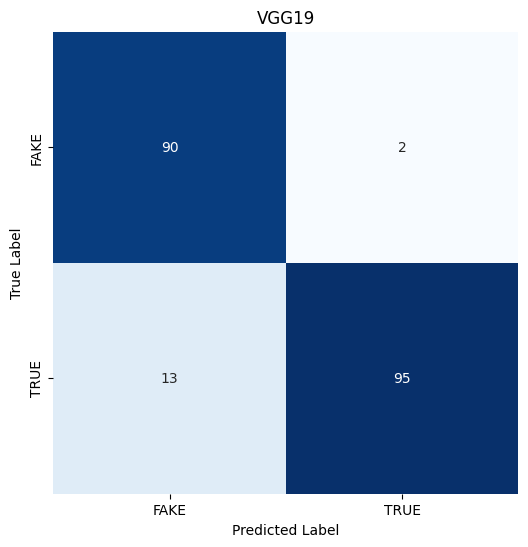

In [ ]:
obj.evaluate(model,data_test,target_test)

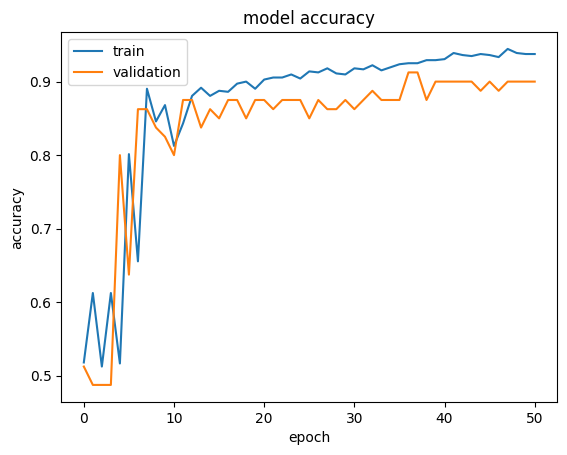

In [ ]:
obj.show(history,'accuracy')

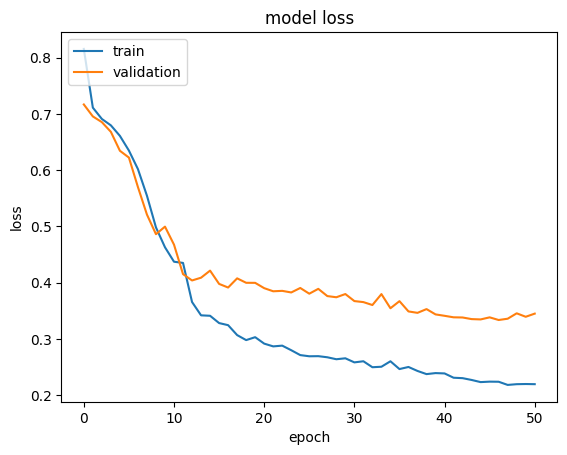

In [ ]:
obj.show(history,'loss')

In [ ]:
print(obj.check_vedio('/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/dData Test_Videos','5.avi'))


from IPython.display import HTML
from base64 import b64encode

video_path ='/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/Data Test_Videos/5.mp4'

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video(video_path)

1/1 [==============================] - 0s 70ms/step
        NonViolence  Violence   prediction
result     0.993298  0.006703  NonViolence


In [ ]:
print(obj.check_vedio('/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/Data Test_Videos','6.mp4'))

from IPython.display import HTML
from base64 import b64encode

video_path ='/content/drive/MyDrive/Colab Notebooks/Violence_detection_project/VGG19/Data Test_Videoso/6.mp4'

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video(video_path)

1/1 [==============================] - 0s 17ms/step
        NonViolence  Violence prediction
result     0.004596  0.995404   Violence
